# Métricas de Clasificación Binaria
---
___

Dado que $\hat{p}(\mathbf{x})$ es el estimador de la probabilidad de pertenecer o no a la población objetivo, entonces condicionando el valor observado puede ser 0 o 1, obtenemos las variables aleatorias que tienen asociadas las distribuciones de los positivos $f_{\hat{Y}|Y=1}(y)$ y negativos $f_{\hat{Y}|Y=0}(y)$. 

<img src='static/distributions.png' width="30%" height="30%">

Para algun corte fijo $c \in \mathbb{R}$ considere la siguiente función: 

$$
T(\hat{Y};c) = 
     \begin{cases}
       \text{1} &\quad c \leq \hat{Y}\\
       \text{0} &\quad \hat{Y} < c \\
     \end{cases}
$$

Las siguientes probas se definen como:
* *Tasa de verdaderos positivos (Recall or Sensitivity):* $P \left[ T(\hat{Y};c)=1|Y=1 \right]=P \left[ \hat{Y} \geq c |Y=1 \right] =1-F_{\hat{Y}|Y=1}(c)=\bar{F}_{\hat{Y}|Y=1}(c)$
* *Tasa de verdaderos negativos (Specificity or presicion):* $P \left[ T(\hat{Y};c)=0|Y=0 \right]=P \left[ \hat{Y} < c |Y=0 \right] =F_{Y|Y=0}(c)$
* *Tasa de falsos positivos (Miss Rate):* $P \left[ T(\hat{Y};c)=1|Y=0 \right]=P \left[ \hat{Y} \geq c |Y=0 \right] =1-F_{\hat{Y}|Y=0}(c)=\bar{F}_{\hat{Y}|Y=0}(c)$
* *Tasa de falsos negativos (Fall-Out):* $P \left[ T(\hat{Y};c)=0|Y=1 \right]=P \left[ \hat{Y} < c |Y=1 \right] =F_{Y|Y=1}(c)$

<img src='static/confusionMatrix.png' width="60%" height="60%">

## Curva ROC
___

La característica operativa del receptor (curva ROC)  fue desarrollado por ingenieros durante la Segunda Guerra Mundial para detectar objetos enemigos en los campos de batalla (Collison, 1998). La curva ROC se define en el espacio ROC $[1,0]\times[1,0]$ 
en su forma paramétrica como un gráfico de TPR versus 1-Especificidad:

$$ROC_{curve} = \left \{ (\bar{F}_{\hat{Y}|Y=0}(c),\bar{F}_{\hat{Y}|Y=1}(c)) : c \in (-\infty,\infty) \ \right \}$$

**Proposición:** La curva Roc puede ser representada como una función de $t \in [0,1]$ como:
$$ROC(t) = 1-F_{\hat{Y}|Y=1}\left( F_{\hat{Y}|Y=0}^{-1} (1-t) \right) $$


finalmente la curva ROC está dada por:

$$ROC_{curve} = \left \{ (t,1-F_{\hat{Y}|Y=1}(F_{\hat{Y}|Y=0}^{-1} (1-t))) : t \in [0,1] \right \}$$

### Propiedades de la curva ROC.

* La curva ROC es la función sobre $[0,1]$ tal que $ROC(0)=$ y $ROC(1)=1$.
* La pendiente de la curva ROC coincide con la razón de verosimilitud:
$$
\begin{align*} 
\frac{d}{dt} ROC(t) & = \frac{f_{\hat{Y}|Y=1}(c)}{f_{\hat{Y}|Y=0}(c)}\\
\end{align*}
$$
* La curva ROC es siempre monótona, esto se da debido a la pendiente positiva.

### Area Bajo la Curva Roc (AUC)

El área bajo la curva (AUC) es la probabilidad de que el modelo califique una clase positiva elegida al azar más alta que una clase negativa elegida al azar.
$$

### El modelo binomial

Si $\hat{Y}|Y=0 \sim N(\mu_0,\sigma_0)$ y $\hat{Y}|Y=1 \sim N(\mu_1, \sigma_1)$, entonces:

* $ROC(t)=\Phi\left(\frac{\mu_1-\mu_0+\sigma_0 \Phi^{-1}(t)}{\sigma_1}\right)$
* $AUC =\Phi\left(\frac{\mu_1-\mu_0}{\sqrt{\sigma_0^2+\sigma_1^2}}\right)$

### Métricas estáticas

Considere la muestra aleatoria de estimadores:

* Positivos = $\{ \hat{y}_{11} = \hat{p}(\mathbf{x}_{11}), ...,  \hat{y}_{1n} = \hat{p}(\mathbf{x}_{1n})\}$
* Negativos = $\{ \hat{y}_{01} = \hat{p}(\mathbf{x}_{01}), ...,  \hat{y}_{0m} = \hat{p}(\mathbf{x}_{0m})\}$

**Evaluando el rendimiento del modelo**:

In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats import norm
import warnings
import seaborn as sns
import random
random.seed(500)
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth',100)
plt.style.use('seaborn-paper')
plt.style.use('seaborn')

In [3]:
def getMvNormalSample(mu,sigma,n):
    columns = ['x'+str(i+1) for i in range(0,len(mu))]
    return pd.DataFrame(np.random.multivariate_normal(mu,sigma,n),columns=columns)

def scatterPlot(plt,datasetPD,col_1,col_2,colorDots='darkblue',label=None,shift=0.05,**kwargs):
    dataPD = datasetPD[[col_1,col_2]]
    plt.scatter(dataPD[col_1],dataPD[col_2],color=colorDots)
    if(label!=None):
        points = datasetPD[[col_1,col_2,label]].values
        for point in points:
            plt.text(point[0]+shift,point[1]+shift,str(point[2]))
    plt.axvline(**kwargs)
    plt.axhline(**kwargs)
    
def plot_confusion_matrix(plt,y_true, y_pred, figsize=(10,10), font_size=16):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "Blues", annot=annot, fmt='', ax=ax, annot_kws={"size": font_size})

,x1,x2,target,amount
468,2.761905,3.439804,0,1619.117524
1247,4.675897,3.959675,0,626.890101
937,7.624827,6.408493,0,534.669624
165,6.921629,4.341059,1,415.908255
1036,2.032670,2.545483,0,806.489952
...,...,...,...,...
939,7.617746,6.409589,0,1149.378521
653,5.553367,6.343235,0,110.256416
978,6.118187,5.211446,0,3717.392562
106,4.617408,5.414481,0,560.163010


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                 1470
Model:                          Logit   Df Residuals:                     1467
Method:                           MLE   Df Model:                            2
Date:                Thu, 01 Dec 2022   Pseudo R-squ.:                  0.8347
Time:                        22:46:25   Log-Likelihood:                -143.51
converged:                       True   LL-Null:                       -868.22
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8209      0.702      2.594      0.009       0.445       3.197
x1             3.0447      0.236     12.892      0.000       2.582       3.508
x2            -4.7588      0.358    -13.275      0.000      -5.461      -4.056
==============================================================================

Possibly complete quasi-separation: A fraction 0.22 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

,x1,x2,target,amount,score
988,4.662430,4.835472,0,239.725441,0.000916
416,3.981110,4.584230,0,189.378352,0.000381
515,4.582169,4.244543,0,672.775971,0.011814
708,5.683411,4.695933,0,157.530117,0.038359
176,5.802755,5.096730,0,181.765193,0.008446
...,...,...,...,...,...
440,5.421438,5.489975,0,576.119694,0.000410
261,7.266749,4.915011,1,540.836398,0.635676
758,6.164840,4.714083,0,225.441525,0.136790
1034,2.917483,4.996042,0,661.594382,0.000002


,x1,x2,target,amount,score
311,4.741607,5.976691,0,1709.818898,0.000005
409,6.676532,6.154714,0,68.797395,0.000792
1184,7.226603,6.824731,0,53.073862,0.000174
434,5.757361,4.216254,1,44.337157,0.328760
1144,4.364100,5.310376,0,87.863027,0.000039
...,...,...,...,...,...
10,3.969331,5.367460,0,388.712949,0.000009
1102,5.636975,5.708089,0,316.428400,0.000280
1198,4.759588,3.166794,0,91.338214,0.775984
518,3.570269,4.257039,0,470.010790,0.000517


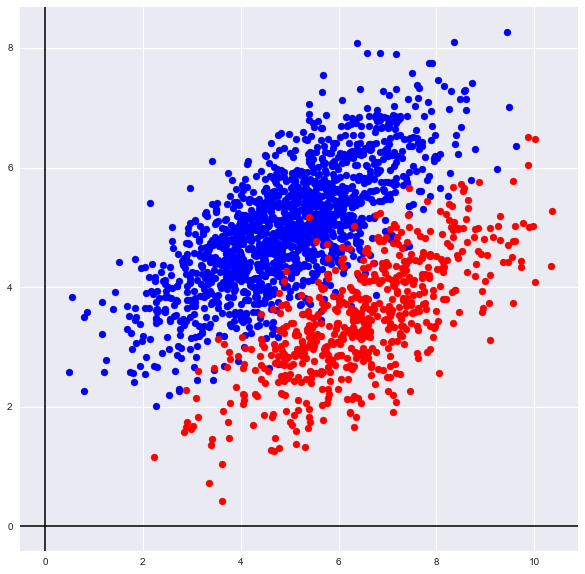

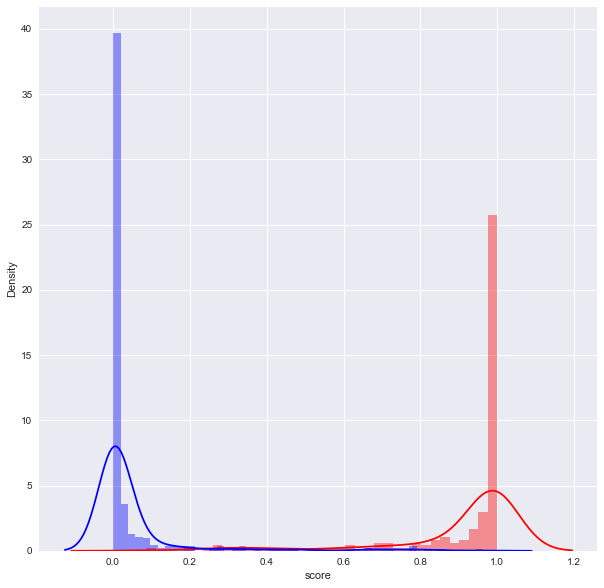

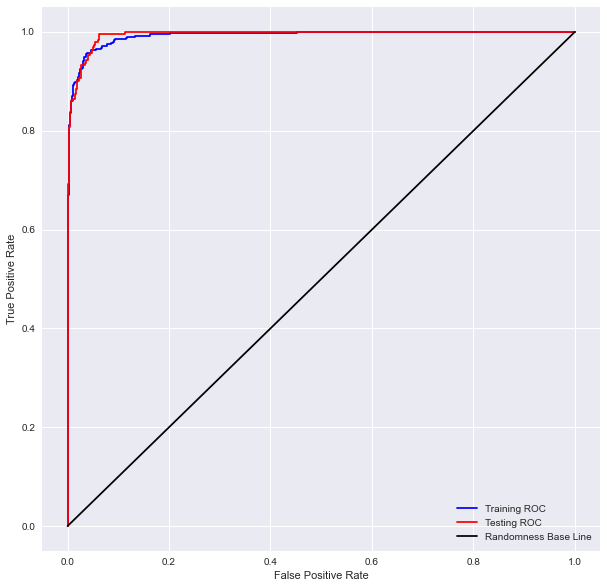

AUC TRAIN: 0.9922062516155239
AUC TEST: 0.9943279109589042
GINI TRAIN: 0.9844125032310478
GINI TEST: 0.9886558219178083


In [4]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
n0 = 1500
n1 = 600
normal_sample_0_df = getMvNormalSample([0+5,0+5],[[2,1],[1,1]],n=n0)
normal_sample_1_df = getMvNormalSample([1.5+5,-1.5+5],[[2,1],[1,1]],n=n1)
normal_sample_0_df['target'] = 0
normal_sample_1_df['target'] = 1
normal_sample_0_df['amount'] = np.random.exponential(scale=500, size=n0)
normal_sample_1_df['amount'] = np.random.exponential(scale=600, size=n1)

features = ['x1','x2']
dataset_df = pd.concat([normal_sample_0_df,normal_sample_1_df]).sample(frac=1)
dataset_df.to_csv('datasets/loans.csv',index=None)
display(dataset_df)

train_df, test_df = train_test_split(dataset_df,test_size=0.3)
train_X = train_df[features]
train_Y = train_df[['target']]

test_X = test_df[features]
test_Y = test_df[['target']]

sm_model = sm.Logit(train_Y, sm.add_constant(train_X)).fit(disp=0)
display(sm_model.summary())

train_df['score'] = sm_model.predict(sm.add_constant(train_X)).copy()
test_df['score'] = sm_model.predict(sm.add_constant(test_X)).copy()

display(train_df)
display(test_df)

train_fpr, train_tpr, train_thresholds  = roc_curve(train_df['target'],train_df['score'])
test_fpr, test_tpr, test_thresholds  = roc_curve(test_df['target'],test_df['score'])

plt.figure(figsize=(10,10))
scatterPlot(plt,normal_sample_0_df,'x1','x2','Blue',color='Black',alpha=0.6)
scatterPlot(plt,normal_sample_1_df,'x1','x2','Red',color='Black',alpha=0.6)

plt.figure(figsize=(10,10))
sns.distplot(test_df[test_df['target']==1]['score'], color='red', label='Positives')
sns.distplot(test_df[test_df['target']==0]['score'], color='blue', label='Negatives')

plt.figure(figsize=(10,10))
plt.plot(train_fpr,train_tpr, linestyle='-', color='blue', label='Training ROC')
plt.plot(test_fpr,test_tpr, linestyle='-', color='red', label='Testing ROC')
plt.plot([0,1],[0,1], color='black', label='Randomness Base Line')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print('AUC TRAIN:',roc_auc_score(train_df['target'],train_df['score']))
print('AUC TEST:',roc_auc_score(test_df['target'],test_df['score']))
print('GINI TRAIN:',2*roc_auc_score(train_df['target'],train_df['score'])-1)
print('GINI TEST:',2*roc_auc_score(test_df['target'],test_df['score'])-1)

# Valores de métrica de corte (umbral)
___


Para algún valor de corte $c \in \mathbb{R}$ las siguientes metricas se definen como:
* Los verdaderos positivos son los valores que realmente son positivos y fueron predichos como positivos por el modelo.
$$TP_c = \lvert \{ T(\hat{y}_{1i},c)=1 \mid \hat{y}_{1i} \in Positives \} \lvert$$

* Los Falsos Negativos son los valores que en realidad son positivos pero el modelo los predijo como negativos. 
$$TN_c = \lvert \{ T(\hat{y}_{0i},c)=0 \mid \hat{y}_{0i} \in Negatives \} \lvert$$

* Los falsos positivos son aquellos que en realidad son negativos pero el modelo dijo que son positivos.
$$TP_c = \lvert \{ T(\hat{y}_{0i},c)=1 \mid \hat{y}_{0i} \in Negatives \} \lvert$$

* Los verdaderos negativos son aquellos valores que en realidad son negativos y el modelo dijo que son negativos.
$$TN_c =  \lvert \{ T(\hat{y}_{1i},c)=0 \mid \hat{y}_{1i} \in Positives \} \lvert$$

Confusion Matrix es básicamente una tabla que consta de los siguientes valores.

$$
CM_c = \left( \begin{array}{cc}
TN_c & FP_c \\
FN_c & TP_c \end{array} \right)
$$

<img src='static/cm.jpeg' width="60%" height="60%">

Antes de entrar en precisión y recall, una nota rápida sobre los errores de Tipo I y Tipo II. Estos términos, que no son exclusivos de los problemas de clasificación en el aprendizaje automático, también son extremadamente importantes cuando se trata de pruebas de hipótesis estadísticas.

* **Type I Error**: Falsos Positivos.
* **Type II Error**: Falsos Negativos.

<img src='static/Precisionrecall.png' width="30%" height="30%">

* Tasa de verdaderos positivos estimada (recall o sensibilidad): la recuperación nos dice cuántos positivos verdaderos (puntos etiquetados como positivos) fueron recuperados o encontrados por nuestro modelo. 
$$TPR_c = \frac{TP_c}{TP_c+FN_c}$$

* Tasa negativa verdadera estimada (Especificidad o Precisión): nos dice cuántos positivos verdaderos (puntos etiquetados como positivos) fueron recuperados o encontrados por nuestro modelo
$$TNR_c = \frac{TN_c}{TN_c+FP_c}$$

* Precisión: la fórmula para la precisión es bastante sencilla, básicamente es la proporción de etiquetas pronosticadas correctamente.
$$ACC_c = \frac{TN_c+TP_c}{TN_c+TP_c+FP_c+FN_c}$$


## Otras métricas comunes:

* Tasa de falsos positivos estimada (Fall out):  
$$FPR_c = \frac{FP_c}{FP_C+TN_c}=1-TNR_c$$

* Tasa de falsos negativos estimada (Miss Rate): 
$$FNR_c = \frac{FN_c}{FN_c+TP}=1-TPR_c$$

* Valor predictivo positivo: 
$$PPV_c = \frac{TP_c}{TP_c+FP_c}$$

* F score (Media armonica de la precision and recall): es una métrica que tiene en cuenta tanto la precisión como el recall, ya que no siempre podemos evaluar ambas y luego tomar la más alta para nuestro modelo. EL F1-Score Nos habla del equilibrio que existe entre precisión y recall. 
$$F_{c}(\beta) = (1+\beta^2) \frac{TNR_c TPR_c}{(1+\beta^2)TNR_c+TPR_c}$$

* Razón de probabilidades de diagnóstico: 
$$DOR_c = \frac{TPR_c TNR_c }{ FPR_c FNR_c}$$

**Ejemplo:** Optimización cuando se conoce la severidad

In [5]:
test_df.sort_values('score',ascending=True,inplace=True)
test_df['profit'] = np.where(test_df['target']==0,test_df.amount*1.15,-test_df.amount*1)
test_df['cumulated_profit'] = test_df['profit'].cumsum()
display(test_df[test_df['cumulated_profit'] == test_df['cumulated_profit'].max()])
test_df

,x1,x2,target,amount,score,profit,cumulated_profit
506,8.698713,5.786109,0,327.870082,0.683785,377.050594,238590.076833


,x1,x2,target,amount,score,profit,cumulated_profit
400,2.143295,5.406882,0,883.762535,2.820730e-08,1016.326916,1016.326916
615,5.394281,7.054894,0,349.837242,2.203960e-07,402.312829,1418.639745
510,4.830146,6.569983,0,247.482220,3.975739e-07,284.604553,1703.244298
1170,0.548699,3.824960,0,116.619356,4.085073e-07,134.112259,1837.356557
1071,4.623608,6.415597,0,78.412717,4.419598e-07,90.174624,1927.531181
...,...,...,...,...,...,...,...
592,9.083643,3.733632,1,164.488183,9.999918e-01,-164.488183,152586.603333
86,7.011933,2.253529,1,517.031174,9.999961e-01,-517.031174,152069.572159
418,10.014687,4.080181,1,1609.655359,9.999975e-01,-1609.655359,150459.916800
163,6.313700,1.651018,1,1600.037446,9.999981e-01,-1600.037446,148859.879353


HEAD:


,x1,x2,target,amount,score,profit,cumulated_profit,target_est
400,2.143295,5.406882,0,883.762535,2.820730e-08,883.762535,883.762535,0
615,5.394281,7.054894,0,349.837242,2.203960e-07,349.837242,1233.599778,0
510,4.830146,6.569983,0,247.482220,3.975739e-07,247.482220,1481.081998,0
1170,0.548699,3.824960,0,116.619356,4.085073e-07,116.619356,1597.701354,0
1071,4.623608,6.415597,0,78.412717,4.419598e-07,78.412717,1676.114071,0


TAIL:


,x1,x2,target,amount,score,profit,cumulated_profit,target_est
592,9.083643,3.733632,1,164.488183,0.999992,-164.488183,119818.550970,1
86,7.011933,2.253529,1,517.031174,0.999996,-517.031174,119301.519796,1
418,10.014687,4.080181,1,1609.655359,0.999997,-1609.655359,117691.864437,1
163,6.313700,1.651018,1,1600.037446,0.999998,-1600.037446,116091.826991,1
550,7.165026,2.070965,1,223.523573,0.999999,-223.523573,115868.303418,1


OPTIMAL THRESHOLD CUTOFF SCORE VALUE:


,x1,x2,target,amount,score,profit,cumulated_profit
755,5.235874,3.869602,0,240.271187,0.342552,240.271187,206467.422942


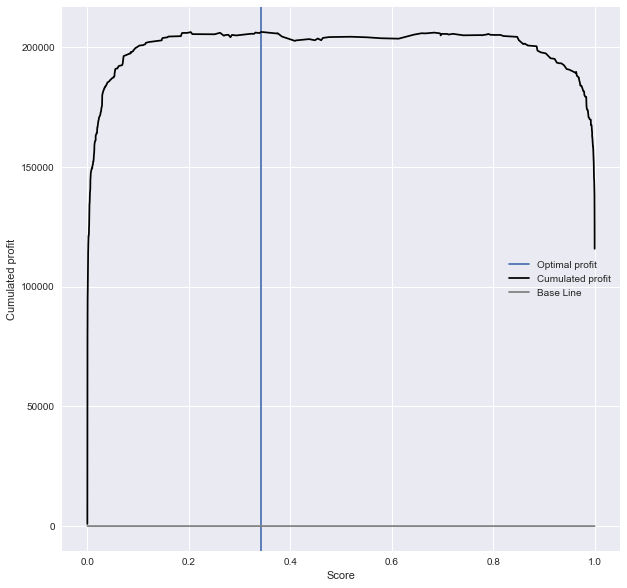

PRECISION: 0.9019607843137255
RECALL: 0.9583333333333334
F1: 0.9292929292929293
ACURACY: 0.9555555555555556
DENIED OPERATIONS: 204
DENIED PERCENTAGE: 0.3238095238095238


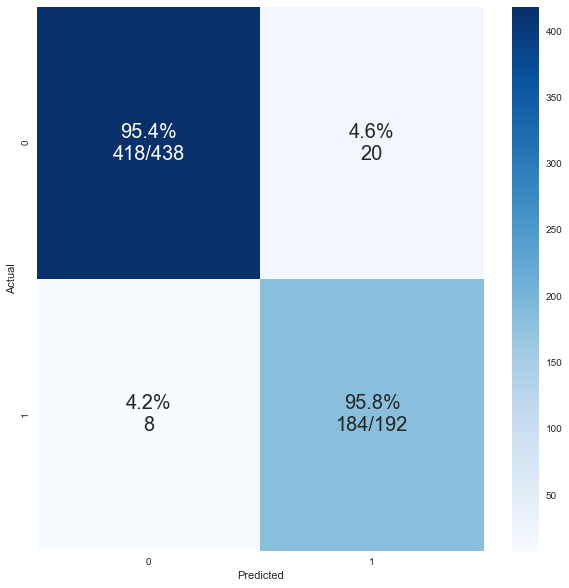

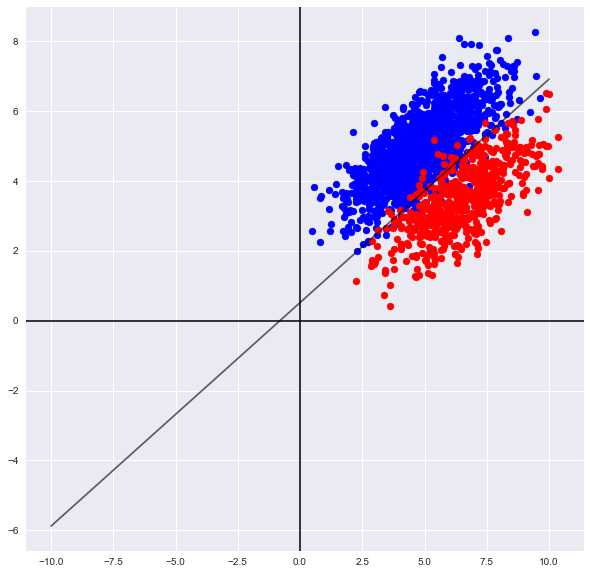

In [6]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

test_df.sort_values('score',ascending=True,inplace=True)
test_df['profit'] = np.where(test_df['target']==0,test_df.amount,-test_df.amount)
test_df['cumulated_profit'] = test_df['profit'].cumsum()
threshold_row = test_df[test_df['cumulated_profit'] == test_df['cumulated_profit'].max()]
threshold_cutoff = threshold_row['score'].values[0]
test_df['target_est'] = np.where(test_df['score']>=threshold_cutoff,1,0)

precision = precision_score(test_df['target'],test_df['target_est'])
recall = recall_score(test_df['target'],test_df['target_est'])
f1 = f1_score(test_df['target'],test_df['target_est'])
accuracy = accuracy_score(test_df['target'],test_df['target_est'])

print('HEAD:')
display(test_df.head(5))
print('TAIL:')
display(test_df.tail(5))
print('OPTIMAL THRESHOLD CUTOFF SCORE VALUE:')
display(threshold_row)

plt.figure(figsize=(10,10))
plt.axvline(x=threshold_cutoff,label='Optimal profit')
plt.plot(test_df['score'].values,test_df['cumulated_profit'].values, linestyle='-', color='Black', label='Cumulated profit')
plt.plot([1,0],[1,0], linestyle='-', color='Gray', label='Base Line')

plt.xlabel('Score')
plt.ylabel('Cumulated profit')
plt.legend()
plt.show()

print('PRECISION:',precision)
print('RECALL:',recall)
print('F1:',f1)
print('ACURACY:',accuracy)
print('DENIED OPERATIONS:',len(test_df[test_df['score']>=threshold_cutoff]))
print('DENIED PERCENTAGE:',len(test_df[test_df['score']>=threshold_cutoff])/len(test_df))

plot_confusion_matrix(plt,test_df['target'],test_df['target_est'],figsize=(10,10),font_size=20)

odds = np.log(threshold_cutoff/(1-threshold_cutoff))
# odds = b0+b1x1+b2x2

beta_0 = sm_model.params[0]
beta_1 = sm_model.params[1]
beta_2 = sm_model.params[2]
x1 = np.linspace(-10, 10, 1000)
x2 = (odds-beta_0-beta_1*x1)*(1/beta_2)

plt.figure(figsize=(10,10))
scatterPlot(plt,normal_sample_0_df,'x1','x2','Blue',color='Black',alpha=0.6)
scatterPlot(plt,normal_sample_1_df,'x1','x2','Red',color='Black',alpha=0.6)
plt.plot(x1, x2,color='Black',alpha=0.6)